### Análisis simbólico

In [1]:
import numpy as np
import scipy.signal as sig
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from pytc2.sistemas_lineales import group_delay, analyze_sys, plot_plantilla, bodePlot
from pytc2.general import print_latex, print_subtitle, a_equal_b_latex_s

In [2]:
#defino mis simbolos

S , Z = sp.symbols('$ Z', complex=True)

W0, Q, K, FS = sp.symbols('W0 Q K Fs', real=True, positive=True)

Tfa = W0**2/(S**2+S*W0/Q+W0**2)

print_latex(a_equal_b_latex_s('Tfa',Tfa))

Tb = K * (Z-1)/(Z+1)

<IPython.core.display.Math object>

In [3]:
Tfd = Tfa.subs(S, Tb)     #Sustituye el símbolo 1 por el 2
print_latex(a_equal_b_latex_s('Tfd',Tfd))   #Trannsforma un simbolo en un string formateado para verlo en LATEX

Tfd = sp.expand(Tfd)    #Si no pongo otros argumentos, resuelve todas las distributivas
#print_latex(a_equal_b_latex_s('Tfd',Tfd))

Tfd = sp.simplify(Tfd) #Simplifica la expresión. No está muy bien definido, pero en este caso saca denom comun y deja en num/den
#print_latex(a_equal_b_latex_s('Tfd',Tfd))

Tfd = sp.expand(Tfd)    #Vuelve a resolver las distributivas. No lo imprimo porque es larguísimo

Tfd = sp.simplify(Tfd)  #Vuelvo a simplificar
#print_latex(a_equal_b_latex_s('Tfd',Tfd))

Tfd = sp.collect(Tfd , Z)   #le digo respecto de qué variable (y sus potencias)quiero que me separe el numerador y den
print_latex(a_equal_b_latex_s('Tfd',Tfd))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Análisis numérico

TypeError: 'NoneType' object is not subscriptable

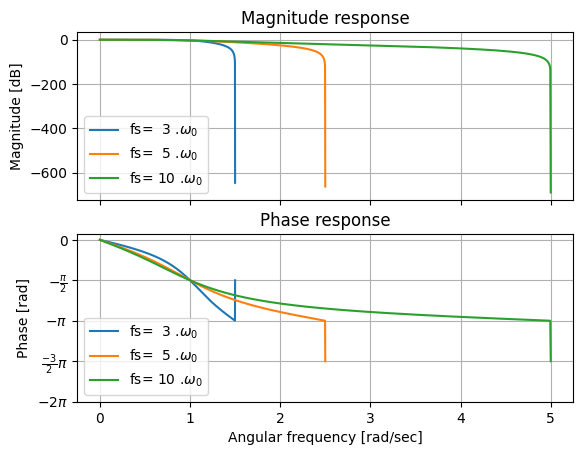

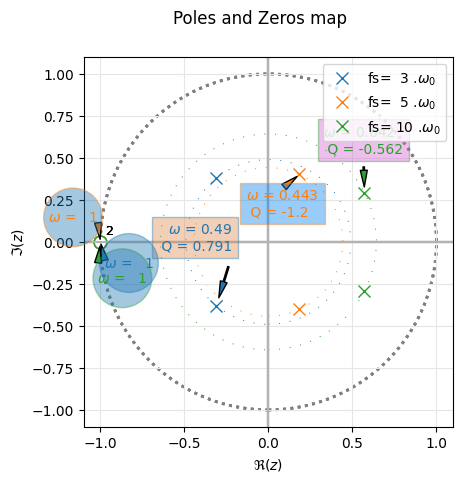

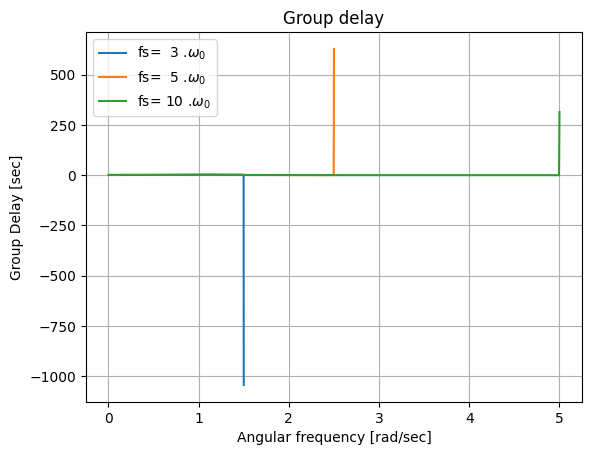

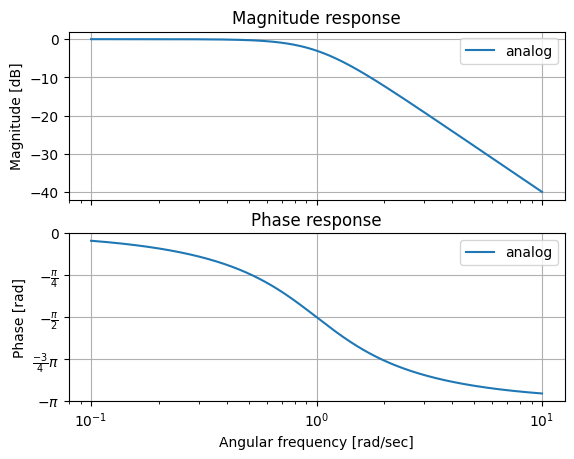

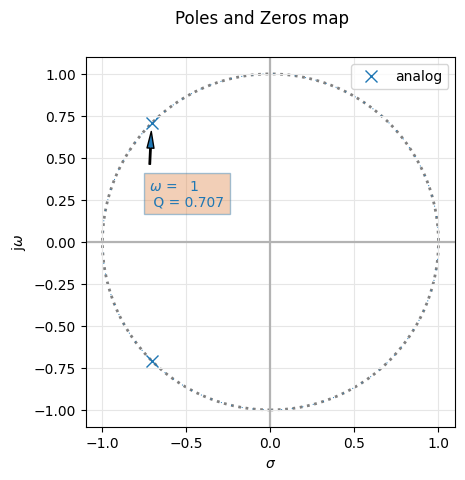

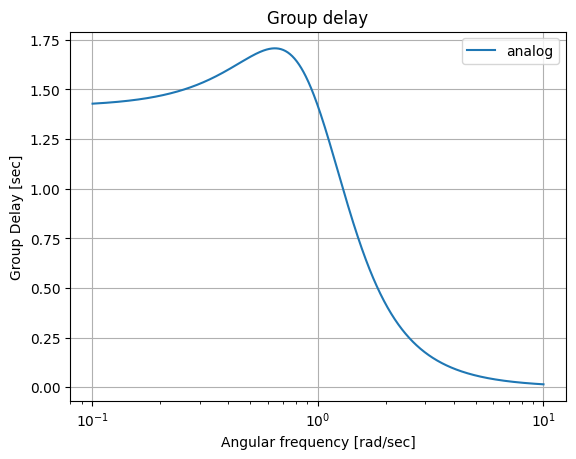

In [5]:
# filtro analógico Butterworth normalizado
ww = 1 # r/s
QQ = np.sqrt(2)/2

this_ts = sp.simplify(sp.expand(Tfa.subs({W0:ww, Q:QQ})))

num, den = sp.fraction(this_ts)   #Devuelve en numerador y den

num = sp.Poly(num,S)   #devuelve en polinomio respecto a veriable especificada
den = sp.Poly(den,S)

num = np.array(num.all_coeffs()).astype(np.float64)
den = np.array(den.all_coeffs()).astype(np.float64)

my_af = sig.TransferFunction(num, den)


# w0=2*np.pi*f0, entonces la mínima frecuencia para que f0 esté en banda digital:
# > 1 * w0/2/np.pi
allfs = np.array([ 3, # correctamente muestreado
                   5, # prewarping a w0
                   10 ]) * ww/2/np.pi # sobremuestreado

all_sys = []
all_sys_desc = []

plt.close('all')

for this_fs in allfs:

    # sin prewarp
    #k_bilineal = 2*this_fs; 
    # con prewarp
    k_bilineal = ww/np.tan(ww/2/this_fs); 

    thiz_tz = sp.simplify(sp.expand(Tfd.subs({K:k_bilineal, Q:QQ, W0:ww})))
    
    num, den = sp.fraction(thiz_tz)

    num = sp.Poly(num,Z)
    den = sp.Poly(den,Z)

    numz = np.array(num.all_coeffs()).astype(np.float64)
    denz = np.array(den.all_coeffs()).astype(np.float64)

    my_df = sig.TransferFunction(numz, denz, dt=1/this_fs)
    
    all_sys += [my_df]
    all_sys_desc += ['fs={:3.0f} .$\omega_0$'.format(this_fs/(ww/2/np.pi))]


# Rta del analógico

# Rta del digital
figaxes = analyze_sys(all_sys, all_sys_desc)
analyze_sys(my_af, 'analog', same_figs=False)
# Haremos notar que el prewarp es capaz de fijar la igualdad de la respuesta 
# del sistema independientemente de la frecuencia de muestreo.

# Respuesta de módulo
figaxes[0][1][0].set_ylim(bottom=-10,top=2)

# Respuesta de retardo
#figaxes[3][1].set_ylim(bottom=0, top=5)